In [1]:
# rewrite by LJN on 6/9/23

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import astropy 
import astropy.units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

In [2]:
# Fetch large AGN table from Yue/Xin, and clean
lookup_table = pd.read_csv("shencatalog_mastmatched_1.5min_allcams-Table 1.csv")
#lookup_table = lookup_table.drop(index=lookup_table.index[::2]) # only needed for Shreya's BBHTable
lookup_table = lookup_table.rename(columns={'RA (J2000)': 'ra', 'Dec (J2000)': 'dec'}) # consider for ang sep
lookup_table['Entry'] = lookup_table['Entry'].astype('int')
# Fix problems with naming?
nfix = True
if nfix:
    for index, row in lookup_table.iterrows():
        sname = row['SDSS Name']
        if len(sname) != 18:
            lookup_table.loc[index, 'SDSS Name'] = lookup_table.loc[index, 'Target Name']
            lookup_table.loc[index, 'Target Name'] = sname
# Fetch SDSS data from Yue file
sdss = pd.read_csv("shentable.csv")
# Fetch targets, add I mag from SDSS
targets = pd.read_csv('8targets.csv', sep=',')
sc_targ = SkyCoord(ra=targets['ra'], dec=targets['dec'], unit=u.deg)
sc_sdss = SkyCoord(ra=sdss['RA'], dec=sdss['DEC'], unit=u.deg)
idx, d2d, d3d = sc_targ.match_to_catalog_sky(sc_sdss) # gets indices of best positional matches assuming all present,
                                                      # could instead add a separation tolerance if this ^ isn't sure
targets['iMAG'] = sdss['MI_Z2'][idx].to_numpy() # ASSUMPTION: lookup_table iMag = MI_Z2 (SDSS I mag norm at z=2)
# Remove targets from lookup_table, if present (unfinished; closest distance is 25")
sc_look = SkyCoord(ra=lookup_table['ra'], dec=lookup_table['dec'], unit=(u.hourangle, u.deg))
idx, d2d, d3d = sc_targ.match_to_catalog_sky(sc_look)
d2d

<Angle [0.00702433, 0.76678332, 0.27838674, 0.95374025, 0.89952156,
        1.54979238, 1.09467981, 1.2437659 ] deg>

In [3]:
targets

,name,filename,z,ra,dec,N_psf,N_sersic,ra_psf,dec_psf,ref,iMAG
0,J0847+3732,ie4701_drz,0.4534,131.816817,37.538293,1,1,-99,-99,Guo19,-24.261912
1,J0852+2004,ie4702_drz,0.4615,133.154237,20.069706,1,1,-99,-99,Guo19,-24.256326
2,J0928+6025,ie4703_drz,0.2959,142.158241,60.422484,1,1,-99,-99,Guo19,-24.402618
3,J1112+1813,ie4704_drz,0.1952,168.128759,18.219798,1,1,-99,-99,Guo19,-22.535430
4,J1229-0035,ie4705_drz,0.4498,187.289675,-0.591741,1,1,-99,-99,Shen13,-24.003090
5,J1345+1144,ie4706_drz,0.1264,206.452052,11.745387,1,1,-99,-99,Liu14,-22.565360
6,J1410+3643,ie4707_drz,0.4495,212.585743,36.722997,1,1,-99,-99,Guo19,-23.950254
7,J1537+0055,ie4708_drz,0.1365,234.274805,0.922998,1,1,-99,-99,Guo19,-22.598245


In [16]:
# Apply selection criteria to lookup_table to discard unhelpful sources, giving ttable (tolerance table)
# NOTE: I comment out here a set of criteria on iMag, z, and central wavelength,
#       as these should be figured out by KNN

CW_tol = 700  # tolerances on various parameters
Mag_tol = 0.5
z_tol = 0.1
expt_min = 150 # minimum exposure time (s)
sep_max = 0.1 # maximum angular separation of HST to SDSS

CW_mean = lookup_table[lookup_table["Filters/Gratings"] == 'F160W']['Central Wavelength'].mean()
Mag_mean = lookup_table[lookup_table["Filters/Gratings"] == 'F160W']['iMAG'].mean()
z_mean = lookup_table[lookup_table["Filters/Gratings"] == 'F160W']['z'].mean()

CW_low, CW_up = CW_mean-CW_tol, CW_mean+CW_tol
Mag_low, Mag_up = Mag_mean-Mag_tol, Mag_mean+Mag_tol
z_low, z_up = z_mean-z_tol, z_mean+z_tol

print(len(lookup_table), "before cuts.")
ttable = lookup_table[lookup_table["Filters/Gratings"].str.contains('F160W') == True] # F160W data available
print(len(ttable), "with F160W.")
ttable = ttable[lookup_table["Instrument"].str.contains('WFC3') == True] # Data is from WFC3
print(len(ttable), "from WFC3.")
ttable = ttable[ttable['Exp Time'] >= expt_min]
print(len(ttable), "with long enough exp. time.")
ttable = ttable[ttable["Ang Sep (')"] <= sep_max]
print(len(ttable), "within separation.")
#ttable = ttable[(ttable['Central Wavelength']>=CW_low) & (ttable['Central Wavelength']<=CW_up)]
#ttable = ttable[(ttable['iMAG']>=Mag_low) & (ttable['iMAG']<=Mag_up)]
#ttable = ttable[(ttable['z']>=z_low) & (ttable['z']<=z_up)]

ttable['myID'] = np.arange(1, len(ttable)+1) # Adding an int label for convenience, moving to first column
cols = ttable.columns.tolist()
ttable = ttable[cols[-1:] + cols[:-1]]
ttable['myID'] = ttable['myID'].astype('int')
ttable.style

2439 before cuts.
365 with F160W.
181 from WFC3.
176 with long enough exp. time.
94 within separation.


/var/folders/22/dh8f6qrs5xxcjd4nzyck348r0000gn/T/ipykernel_23402/1840681789.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ttable = ttable[lookup_table["Instrument"].str.contains('WFC3') == True] # Data is from WFC3


,myID,Entry,SDSS Name,Target Name,Target Descrip,ra,dec,z,iMAG,Start Time,Exp Time,Instrument,Filters/Gratings,Central Wavelength,Ang Sep (')
20,1,790,002025.22+154054.7,3C9,GALAXY;JET;KNOT;NUCLEUS;QUASAR;RADIO GALAXY,00 20 25.200,+15 40 55.00,2.008700,-28.660000,2014-12-22 06:43:28,897.697000,WFC3,F160W,15369.176000,0.005000
34,2,1377,003516.88-104731.2,J0035-1047,GALAXY;QUASAR,00 35 16.880,-10 47 31.20,0.796700,-24.770000,2013-09-17 11:28:43,2055.034000,WFC3,F160W,15369.176000,0.000393
61,3,2397,005838.95-102651.3,J0058-1026,GALAXY;QUASAR,00 58 38.950,-10 26 51.30,0.489800,-24.540000,2013-09-17 14:40:57,2055.034000,WFC3,F160W,15369.176000,0.001000
80,4,3381,012403.77+004432.6,SDSS-J012403.77+004432.7,GALAXY;QUASAR,01 24 03.782,+00 44 32.67,3.834300,-29.380000,2015-12-16 15:34:54,2611.751000,WFC3,F160W,15369.176000,0.003000
96,5,3816,013203.46-093153.6,J0132-0931,GALAXY;INTERACTING GALAXY,01 32 03.460,-09 31 53.60,0.189800,-22.520000,2012-05-30 12:43:11,2611.751000,WFC3,F160W,15369.176000,0.001000
109,6,4186,013901.40-082444.0,SDSS-J013901.40-082443.9,GALAXY;QSO,01 39 01.403,-08 24 44.08,3.016100,-28.200000,2016-01-09 11:58:01,2611.751000,WFC3,F160W,15369.176000,0.003000
114,7,4462,014516.59-094517.3,UM673,GALAXY;HIGH REDSHIFT GALAXY;QSO,01 45 16.700,-09 45 11.70,2.730000,-29.900000,2010-11-02 16:06:56,8093.098000,WFC3,F160W,15369.176000,0.097000
242,8,7922,031036.84+005521.7,SDSS-J031036.84+005521.7,GALAXY;QSO,03 10 36.851,+00 55 21.73,3.782600,-28.150000,2015-12-25 15:49:00,2611.751000,WFC3,F160W,15369.176000,0.003000
269,9,10154,073820.09+275045.2,F2M0738+2750,GALAXY;HIGH REDSHIFT GALAXY;QUASAR,07 38 20.101,+27 50 45.51,2.000000,-26.200000,2013-03-19 12:21:13,1596.926000,WFC3,F160W,15369.176000,0.014000
294,10,11261,075054.64+425219.2,2MASSIJ0750546+425219,GALAXY;QUASAR,07 50 54.728,+42 52 19.19,1.896500,-29.820000,2017-02-15 16:53:05,480.874000,WFC3,F160W,15369.176000,0.001000


In [6]:
# I assemble arrays of the coordinates of note (CoN) for KNN: from ttable (ttab_con) and the targets (targ_con)
ttab_con = np.asarray([ttable['z'].to_numpy(), ttable['iMAG'].to_numpy()]).T
targ_con = np.asarray([targets['z'].to_numpy(), targets['iMAG'].to_numpy()]).T

In [7]:
# Run the KNN.  Will return a number of nearest neighbors ~ len(targets) * nn, minus duplicates
# Toggle minimum sample size here:
msc = True
nn = 2
minsamp = 20 # minimum sample size, if toggled (inefficient, and irrespective of distances)
nnbr = NearestNeighbors(n_neighbors=nn).fit(ttab_con)
dist, idx = nnbr.kneighbors(targ_con)
idx = np.unique(idx)
if msc:
    while len(idx) < minsamp:
        nn+=1
        nnbr = NearestNeighbors(n_neighbors=nn).fit(ttab_con)
        dist, idx = nnbr.kneighbors(targ_con)
        idx = np.unique(idx)

In [8]:
# Create control sample table (control_tab)
control_tab = ttable.iloc[idx]
# Use RA and DEC from SDSS Names? Convert RA and DEC to decimal degrees for convenience?  Round them?
sdssn = True
conv = True
rnd = False
if sdssn:
    for index, row in control_tab.iterrows():
        rastr = (row['SDSS Name'][0:2], row['SDSS Name'][2:4], row['SDSS Name'][4:9])
        decstr = (row['SDSS Name'][9:12], row['SDSS Name'][12:14], row['SDSS Name'][14:])
        control_tab.loc[index, ['ra', 'dec']] = ["%s %s %s" %  rastr, "%s %s %s" %  decstr]
if conv:
    for index, row in control_tab.iterrows():
        wherestr = row['ra'] + ' ' + row['dec']
        pos = SkyCoord(wherestr, unit=(u.hourangle, u.deg), frame='icrs')
        if rnd:
            control_tab.loc[index, ['ra', 'dec']] = ["%.6f" % pos.ra.deg, "%.6f" % pos.dec.deg]
        else:
            control_tab.loc[index, ['ra', 'dec']] = [pos.ra.deg, pos.dec.deg]

control_tab

,myID,Entry,SDSS Name,Target Name,Target Descrip,ra,dec,z,iMAG,Start Time,Exp Time,Instrument,Filters/Gratings,Central Wavelength,Ang Sep (')
34,2,1377,003516.88-104731.2,J0035-1047,GALAXY;QUASAR,8.820333,-10.792,0.7967,-24.77,2013-09-17 11:28:43,2055.034,WFC3,F160W,15369.176,0.000393
61,3,2397,005838.95-102651.3,J0058-1026,GALAXY;QUASAR,14.662292,-10.447583,0.4898,-24.54,2013-09-17 14:40:57,2055.034,WFC3,F160W,15369.176,0.001000
96,5,3816,013203.46-093153.6,J0132-0931,GALAXY;INTERACTING GALAXY,23.014417,-9.531556,0.1898,-22.52,2012-05-30 12:43:11,2611.751,WFC3,F160W,15369.176,0.001000
394,14,16846,083158.49+503444.1,J0831+5034,GALAXY;QUASAR,127.993708,50.578917,0.5308,-23.74,2013-12-17 10:50:36,2421.774,WFC3,F160W,15369.176,0.011000
406,16,17232,083417.90+491439.2,J0834+4914,GALAXY;INTERACTING GALAXY,128.574583,49.244222,0.1731,-22.83,2012-04-24 18:49:21,2811.753,WFC3,F160W,15369.176,0.016000
491,19,22107,090133.42+031412.4,SDSSJ0901+0314,GALAXY;STARBURST,135.38925,3.236778,0.4586,-23.55,2015-04-24 15:53:42,2611.751,WFC3,F160W,15369.176,0.017000
547,22,24536,091501.71+241812.1,SED4,GALAXY;ACCRETION DISK;QUASAR;RADIO GALAXY,138.757125,24.303361,0.8440,-23.79,2017-02-25 14:41:24,697.128,WFC3,F160W,15369.176,0.005000
626,25,27704,093027.21+240232.7,J0930+2402,GALAXY;QUASAR,142.613375,24.042417,0.5592,-23.97,2013-12-16 12:31:45,2421.774,WFC3,F160W,15369.176,0.021000
967,33,37785,102434.71+555626.4,J1024+5556,GALAXY;INTERACTING GALAXY,156.144625,55.940667,0.1968,-22.68,2012-04-01 07:26:25,2811.753,WFC3,F160W,15369.176,0.013000
1028,37,40734,104133.43-000236.3,J1041-0002,GALAXY;INTERACTING GALAXY,160.389292,-0.043417,0.2355,-22.55,2013-03-22 13:11:26,2611.751,WFC3,F160W,15369.176,0.018000


In [9]:
# Save the control sample to a csv for use elsewhere
control_tab.to_csv('controlsample.csv', index=False)

In [10]:
mask = [id in [2, 3, 14, 25, 40, 44, 48, 85] for id in control_tab['myID']]
control_tab2 = control_tab[mask]
control_tab2.to_csv('control.csv', index=False)
control_tab2['Target Name']

34      J0035-1047
61      J0058-1026
394     J0831+5034
626     J0930+2402
1125    J1118+2336
1206    J1147-0146
1325    J1211+1438
2315     IBZF08023
Name: Target Name, dtype: object

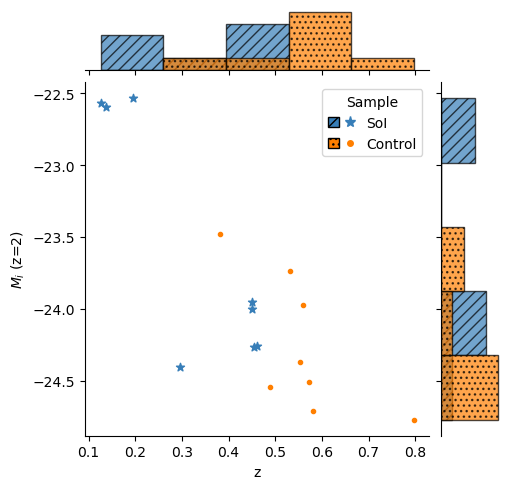

In [11]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
CBcc = CB_color_cycle # shortname

# Dual scatterplot/histogram to show sample is well matched
z = np.append(targets['z'].values, control_tab2['z'].values)
iMag = np.append(targets['iMAG'].values, control_tab2['iMAG'].values)
kind = (['SoI'] * len(targets['z'])) + (['Control'] * len(control_tab2['z']))
colors = ([CBcc[0]] * len(targets['z'])) + ([CBcc[1]] * len(control_tab2['z']))
sym = (['*'] * len(targets['z'])) + (['.'] * len(control_tab2['z']))
scatterdf = pd.DataFrame({
    'z' : z,
    '$M_i$ (z=2)' : iMag,
    'which' : kind,
    'sym' : sym})

g = sns.JointGrid(data=scatterdf, x="z", y="$M_i$ (z=2)", hue='which', height=5)
# Scatterplot (custom instead of plot_joint(scatter)) because I want different symbols
seen = []
for i, zi in enumerate(z):
    if kind[i] in seen:
        g.ax_joint.scatter(zi, iMag[i], color=colors[i], marker=sym[i])
    else:
        g.ax_joint.scatter(zi, iMag[i], color=colors[i], marker=sym[i], label=kind[i])
        seen.append(kind[i])
# Histograms (again custom to use hashing)
#g = g.plot_marginals(sns.histplot, hatchs='/')
# Define bins
z_bins = np.histogram_bin_edges(z, bins='auto')
mag_bins = np.histogram_bin_edges(iMag, bins='auto')

# Plot z histograms (top marginal, ax_marg_x)
g.ax_marg_x.hist(targets['z'], bins=z_bins, color=CBcc[0],
                 histtype='bar', hatch='///', edgecolor='black', alpha=0.7, label='SoI')
g.ax_marg_x.hist(control_tab2['z'], bins=z_bins, color=CBcc[1],
                 histtype='bar', hatch='...', edgecolor='black', alpha=0.7, label='Control')

# Plot iMAG histograms (right marginal, ax_marg_y)
g.ax_marg_y.hist(targets['iMAG'], bins=mag_bins, color=CBcc[0],
                 histtype='bar', hatch='///', edgecolor='black', alpha=0.7, label='SoI',
                 orientation='horizontal')
g.ax_marg_y.hist(control_tab2['iMAG'], bins=mag_bins, color=CBcc[1],
                 histtype='bar', hatch='...', edgecolor='black', alpha=0.7, label='Control',
                 orientation='horizontal')
# remove the legend label created by seaborn
#handles, labels = g.ax_joint.get_legend_handles_labels()
#g.ax_joint.legend(handles=handles[0:], labels=labels[0:]);
# customize legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# Define hatch and marker info for each group
legend_handles = [
    (
        Patch(facecolor=CBcc[0], edgecolor='black', hatch='///'),
        Line2D([0], [0], marker='*', color=CBcc[0], linestyle='None', markersize=8)
    ),
    (
        Patch(facecolor=CBcc[1], edgecolor='black', hatch='...'),
        Line2D([0], [0], marker='.', color=CBcc[1], linestyle='None', markersize=8)
    )
]

legend_labels = ['SoI', 'Control']

# Create the combined legend with tuples and custom handler
g.ax_joint.legend(legend_handles, legend_labels,
                  title='Sample',
                  handler_map={tuple: HandlerTuple(ndivide=None)})

In [12]:
g.savefig('controlmatch.jpg')

In [13]:
# KS Statistics
from scipy import stats
from astropy.table import Table
z1, z2 = targets['z'].values, control_tab2['z'].values
m1, m2 = targets['iMAG'].values, control_tab2['iMAG'].values
ksz = stats.kstest(z1, z2)
ksm = stats.kstest(m1, m2)
t = Table([['z', 'iMag'], [ksz.statistic, ksm.statistic], [ksz.pvalue, ksm.pvalue]], names=['', 'KS Stat', 'KS p-val'])
t

col0,KS Stat,KS p-val
str4,float64,float64
z,0.875,0.002486402486402486
iMag,0.5,0.2826728826728826
